In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.2 MB/s eta 0:00:00


In [2]:
# импорты для работы с данными, для визуализации, для моделей и т.д.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# загружаем данные для регрессии

# реальная практическая задача - оценка стоимости драгоценности на основе её характеристик при торговле
csv_path = "diamonds.csv"

df_reg = pd.read_csv(csv_path)
# берем случайную выборку 60% для ускорения работы программы
df_reg = df_reg.sample(frac=0.6, random_state=42)

# анализируем входные данные
df_reg.head()
df_reg.shape
df_reg.info()
# df_reg.describe()
df_reg.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 33553 to 35687
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    30000 non-null  float64
 1   cut      30000 non-null  object 
 2   color    30000 non-null  object 
 3   clarity  30000 non-null  object 
 4   depth    30000 non-null  float64
 5   table    30000 non-null  float64
 6   price    30000 non-null  int64  
 7   x        30000 non-null  float64
 8   y        30000 non-null  float64
 9   z        30000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.5+ MB


,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


In [4]:
# загружаем данные для классификации

# реальная практическая задача - прогнозирование сбоев оборудования помогает минимизировать ущерб производству и экономить ресурсы
csv_path = "predictive_maintenance.csv"

df_clf = pd.read_csv(csv_path)

# анализируем входные данные
df_clf.head()
df_clf.shape
df_clf.info()
df_clf.describe()
df_clf.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


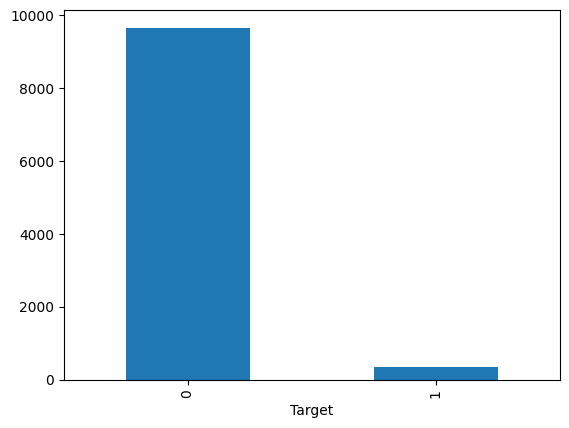

In [5]:
# подготавливаем данные

# делим признаки на числовые и категориальные
num_cols_reg = df_reg.drop(columns=["price"]).select_dtypes(include=["number"]).columns.tolist()
cat_cols_reg = df_reg.drop(columns=["price"]).select_dtypes(include=["object"]).columns.tolist()

num_cols_clf = df_clf.drop(columns=["Target"]).select_dtypes(include=["number"]).columns.tolist()
cat_cols_clf = df_clf.drop(columns=["Target"]).select_dtypes(include=["object"]).columns.tolist()

# определяем признаки и таргет
X_reg = df_reg.drop(columns=["price"])
y_reg = df_reg["price"]

X_clf = df_clf.drop(columns=["Target"])
y_clf = df_clf["Target"]

# определяем обучающие и тестовые выборки
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# смотрим изначальное распределение классов для классификации
df_clf["Target"].value_counts().plot(kind='bar')
plt.show()


In [6]:
# обычная классификация

# стандартизируем числовые признаки, применяем OneHot
preprocessor_clf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_clf),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_clf),
    ]
)


clf_baseline = Pipeline([
    ("prep", preprocessor_clf),
    ("model", KNeighborsClassifier())
])

clf_baseline.fit(Xc_train, yc_train)
yc_pred = clf_baseline.predict(Xc_test)


acc = accuracy_score(yc_test, yc_pred)
f1 = f1_score(yc_test, yc_pred)

print(acc, f1)


0.994 0.8928571428571429


In [7]:
# обычная регрессия

# стандартизируем числовые признаки, применяем OneHot
preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_reg),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_reg),
    ]
)


reg_baseline = Pipeline([
    ("prep", preprocessor_reg),
    ("model", KNeighborsRegressor())
])

reg_baseline.fit(Xr_train, yr_train)
yr_pred = reg_baseline.predict(Xr_test)


mae = mean_absolute_error(yr_test, yr_pred)
rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
r2 = r2_score(yr_test, yr_pred)

print(mae, rmse, r2)

435.7582666666666 820.7299605676238 0.9570891843219034


лучшие параметры: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'model__weights': 'uniform'}
0.9945 0.9026548672566371


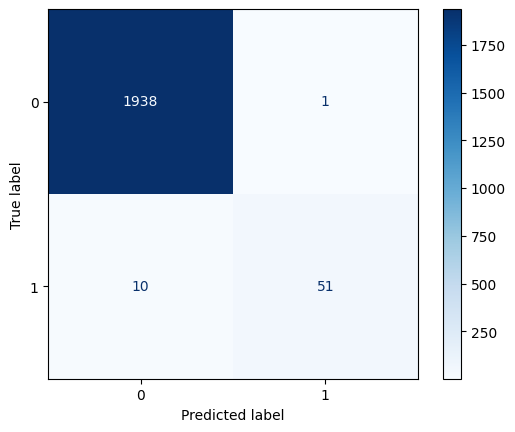

In [8]:
# улучшенная классификация

# используем TargetEncoder вместо OneHot
preprocessor_clf_imp = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_clf),
        ("cat", TargetEncoder(), cat_cols_clf),
    ]
)

clf_pipe = Pipeline([
    ("prep", preprocessor_clf_imp),
    ("model", KNeighborsClassifier())
])

# подбираем гиперпараметры через GridSearchCV
params = {
    "model__n_neighbors": [3, 5, 7],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan"]
}

clf_grid = GridSearchCV(
    clf_pipe,
    params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

clf_grid.fit(Xc_train, yc_train)

print("лучшие параметры:", clf_grid.best_params_)
best_clf = clf_grid.best_estimator_
yc_pred_imp = best_clf.predict(Xc_test)

acc_imp = accuracy_score(yc_test, yc_pred_imp)
f1_imp = f1_score(yc_test, yc_pred_imp)

print(acc_imp, f1_imp)

ConfusionMatrixDisplay.from_predictions(
    yc_test,
    yc_pred_imp,
    cmap="Blues"
)


лучшие параметры: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'distance'}
392.6925350257976 815.8711703048348 0.9575957516715741


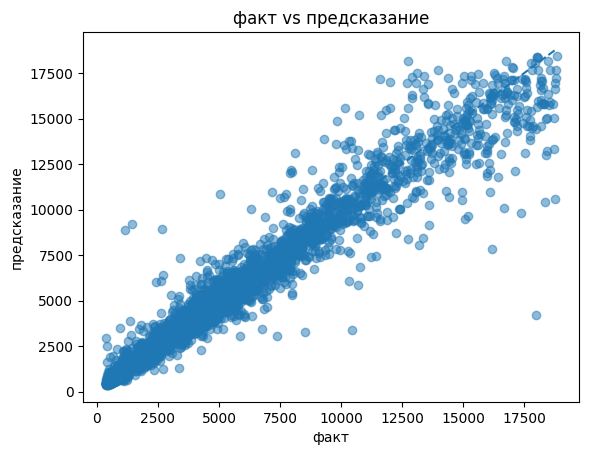

In [9]:
# улучшенная регрессия

# используем TargetEncoder вместо OneHot
preprocessor_reg_imp = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_reg),
        ("cat", TargetEncoder(), cat_cols_reg),
    ]
)

reg_pipe = Pipeline([
    ("prep", preprocessor_reg_imp),
    ("model", KNeighborsRegressor())
])

# подбираем гиперпараметры через GridSearchCV
reg_grid = GridSearchCV(
    reg_pipe,
    params,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

reg_grid.fit(Xr_train, yr_train)

print("лучшие параметры:", reg_grid.best_params_)
best_reg = reg_grid.best_estimator_
yr_pred_imp = best_reg.predict(Xr_test)

mae_imp = mean_absolute_error(yr_test, yr_pred_imp)
rmse_imp = np.sqrt(mean_squared_error(yr_test, yr_pred_imp))
r2_imp = r2_score(yr_test, yr_pred_imp)

print(mae_imp, rmse_imp, r2_imp)

plt.scatter(yr_test, yr_pred_imp, alpha=0.5)
plt.plot([yr_test.min(), yr_test.max()],
         [yr_test.min(), yr_test.max()],
         linestyle="--")
plt.xlabel("факт")
plt.ylabel("предсказание")
plt.title("факт vs предсказание")
plt.show()


In [10]:
# своя классификация

class MyKNNСlf:
    def __init__(self, n_neighbors=3, metric="euclidean"):
        self.k = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def distance(self, a, b):
        if self.metric == "euclidean":
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(a - b))

    def predict(self, X):
        X = np.array(X)
        predictions = []

        for x in X:
            distances = np.array([self.distance(x, train_x) for train_x in self.X_train])
            k_idx = distances.argsort()[:self.k]
            k_labels = self.y_train[k_idx]
            most_common = Counter(k_labels).most_common(1)[0][0]
            predictions.append(most_common)

        return np.array(predictions)

# используем улучшенный препроцессор
my_clf_pipe = Pipeline([
    ("prep", preprocessor_clf_imp),
    ("model", MyKNNСlf(n_neighbors=3, metric="euclidean"))
])

my_clf_pipe.fit(Xc_train, yc_train)
yc_pred_my = my_clf_pipe.predict(Xc_test)

acc_my = accuracy_score(yc_test, yc_pred_my)
f1_my = f1_score(yc_test, yc_pred_my)

print(acc_my, f1_my)


0.9945 0.9026548672566371


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [12]:
# своя регрессия

class MyKNNReg:
    def __init__(self, n_neighbors=3, metric="manhattan"):
        self.k = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def distance(self, a, b):
        if self.metric == "euclidean":
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(a - b))

    def predict(self, X):
        X = np.array(X)
        preds = []

        for x in X:
            distances = np.array([self.distance(x, train_x) for train_x in self.X_train])
            k_idx = distances.argsort()[:self.k]
            preds.append(np.mean(self.y_train[k_idx]))

        return np.array(preds)

# используем улучшенный препроцессор
my_reg_pipe = Pipeline([
    ("prep", preprocessor_reg_imp),
    ("model", MyKNNReg(n_neighbors=3, metric="manhattan"))
])

my_reg_pipe.fit(Xr_train, yr_train)
yr_pred_my = my_reg_pipe.predict(Xr_test)

mae_my = mean_absolute_error(yr_test, yr_pred_my)
rmse_my = np.sqrt(mean_squared_error(yr_test, yr_pred_my))
r2_my = r2_score(yr_test, yr_pred_my)

print(mae_my, rmse_my, r2_my)


410.2013333333333 842.8391315688325 0.9547461454351783


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [13]:
# сравнение всех реализаций между собой
# по итогам замеров - лучше всего себя показывает улучшенный бейзлайн

print("\nклассификация\n")
print("модель\t\t\tAccuracy\tF1-score")
print(f"SKL бейзлайн\t\t{acc:.4f}\t\t{f1:.4f}")
print(f"SKL улучшенная\t\t{acc_imp:.4f}\t\t{f1_imp:.4f}")
print(f"MyKNN\t\t\t{acc_my:.4f}\t\t{f1_my:.4f}")

print("\nрегрессия\n")
print("модель\t\t\tMAE\t\tRMSE\t\tR²")
print(f"SKL бейзлайн\t\t{mae:.2f}\t\t{rmse:.2f}\t\t{r2:.4f}")
print(f"SKL улучшенная\t\t{mae_imp:.2f}\t\t{rmse_imp:.2f}\t\t{r2_imp:.4f}")
print(f"MyKNN\t\t\t{mae_my:.2f}\t\t{rmse_my:.2f}\t\t{r2_my:.4f}")



классификация

модель			Accuracy	F1-score
SKL бейзлайн		0.9940		0.8929
SKL улучшенная		0.9945		0.9027
MyKNN			0.9945		0.9027

регрессия

модель			MAE		RMSE		R²
SKL бейзлайн		435.76		820.73		0.9571
SKL улучшенная		392.69		815.87		0.9576
MyKNN			410.20		842.84		0.9547
